#### Load Libraries

In [3]:
# !pip install tensorflow
import tensorflow as tf
tf.config.list_physical_devices('gpu')

2022-09-21 21:24:45.043836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 21:24:45.163966: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-21 21:24:45.662870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tukl/anaconda3/envs/adil-eeg/lib/
2022-09-21 21:24:45.663015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_pl

[]

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices("GPU"))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, AveragePooling2D,AvgPool2D, Dropout, Input, Convolution2D, ZeroPadding2D, Add, GlobalAveragePooling2D, concatenate,ReLU
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

#### Confusion Matrix

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Set Path Variable

In [13]:
main_directory = '/home/FYP/Final'
class_labels = ['normal', 'slowing-wave', 'spike-and-wave']

In [14]:

for cls in class_labels:
    bad_imgs = []
    img_dir = main_directory + '/' + cls
    for filename in os.listdir(img_dir):
        if filename.endswith('.png'):
            try:
                img = Image.open(img_dir + '/' + filename ) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                bad_imgs.append(filename)
                print('Bad file:', filename) # print out the names of corrupt files
                os.remove(img_dir + '/' + filename)
    print('Amount of Bad Images in Dataset :',len(bad_imgs))

Amount of Bad Images in Dataset : 0
Amount of Bad Images in Dataset : 0
Amount of Bad Images in Dataset : 0


#### Data Processing

In [54]:
random.seed(444)



# Organize into test, train and validations folders

os.chdir(main_directory)

if os.path.isdir('train/normal') is False:
    os.makedirs('train/normal')
    os.makedirs('train/spike-and-wave')
    os.makedirs('train/slowing-wave')

    os.makedirs('valid/normal')
    os.makedirs('valid/spike-and-wave')
    os.makedirs('valid/slowing-wave')

    os.makedirs('test/normal')
    os.makedirs('test/spike-and-wave')
    os.makedirs('test/slowing-wave')
    
    capped_size = 70000
    len_normal = len(os.listdir(main_directory + '/' + 'normal'))
    len_spw = len(os.listdir(main_directory + '/' + 'spike-and-wave'))
    len_sw = len(os.listdir(main_directory + '/' + 'slowing-wave'))
    print('Amoount of imgs in dataset: ',len_normal,len_spw,len_sw)
    
    for c in random.sample(glob.glob('normal/*'), int(len_normal*0.7)):
        shutil.move(c, 'train/normal')
    for c in random.sample(glob.glob('spike-and-wave/*'), int(len_spw*0.7)):
        shutil.move(c, 'train/spike-and-wave')
    for c in random.sample(glob.glob('slowing-wave/*'), int(len_sw*0.7)):
        shutil.move(c, 'train/slowing-wave')

    for c in random.sample(glob.glob('normal/*'), int(len_normal*0.15)):
        shutil.move(c, 'valid/normal')
    for c in random.sample(glob.glob('spike-and-wave/*'), int(len_spw*0.15)):
        shutil.move(c, 'valid/spike-and-wave')
    for c in random.sample(glob.glob('slowing-wave/*'), int(len_sw*0.15)):
        shutil.move(c, 'valid/slowing-wave')

    for c in random.sample(glob.glob('normal/*'), int(len_normal*0.15)):
        shutil.move(c, 'test/normal')
    for c in random.sample(glob.glob('spike-and-wave/*'), int(len_spw*0.15)):
        shutil.move(c, 'test/spike-and-wave')
    for c in random.sample(glob.glob('slowing-wave/*'), int(len_sw*0.15)):
        shutil.move(c, 'test/slowing-wave')

os.chdir('../../')

#### Image Processing

In [89]:
train_path = main_directory + '/train' + '/'
valid_path = main_directory + '/valid' + '/'
test_path = main_directory + '/test' + '/'

In [90]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [91]:
train_batches = train_datagen.flow_from_directory(directory = train_path, target_size = (224, 224), classes = class_labels, batch_size = 16, shuffle = True)
valid_batches = valid_datagen.flow_from_directory(directory = valid_path, target_size = (224, 224), classes = class_labels, batch_size = 8)
test_batches = test_datagen.flow_from_directory(directory = test_path, target_size = (224, 224), classes = class_labels, batch_size = 8, shuffle = False)
print(train_batches.class_indices)
print(valid_batches.class_indices)
print(test_batches.class_indices)

Found 501324 images belonging to 3 classes.
Found 107426 images belonging to 3 classes.
Found 107426 images belonging to 3 classes.
{'normal': 0, 'slowing-wave': 1, 'spike-and-wave': 2}
{'normal': 0, 'slowing-wave': 1, 'spike-and-wave': 2}
{'normal': 0, 'slowing-wave': 1, 'spike-and-wave': 2}


In [58]:
assert train_batches.n > 0
assert valid_batches.n > 0
assert test_batches.n > 0
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

#### Plot Images

In [59]:
from PIL import Image
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [60]:
imgs, train_labels = next(train_batches)

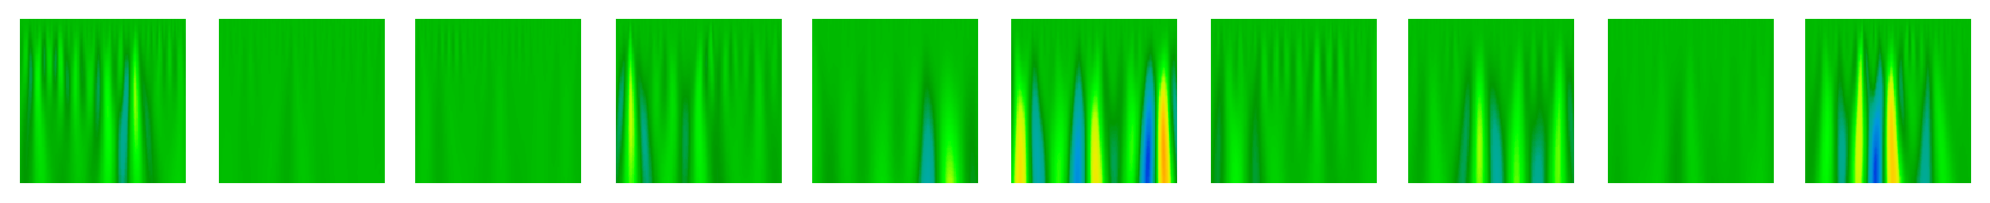

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [61]:
plotImages(imgs) 
print(train_labels)

In [62]:
imgs[0].shape

(224, 224, 3)

# Model Implementation

### Prepare Callbacks

In [92]:
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    verbose = 1,
    mode = 'auto'
)

In [93]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode = 'auto',
                              patience=2, min_lr=0.00001,verbose = 1)

In [94]:

os.chdir(main_directory)

In [98]:
checkpoint_filepath = '/home/FYP/Final/'
mc2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

## Google LeNEt

In [100]:
##### Google LeNet

###### Build Model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

def GoogLeNet():
    # input layer 
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(3, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(3, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(3, activation = 'softmax')(X)

    # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model

google_lenet = GoogLeNet()

google_lenet.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_177 (Conv2D)            (None, 109, 109, 64  9472        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_177[0][0]']             
 )                                                                                        

                                                                                                  
 conv2d_202 (Conv2D)            (None, 12, 12, 24)   12312       ['concatenate_29[0][0]']         
                                                                                                  
 max_pooling2d_45 (MaxPooling2D  (None, 12, 12, 512)  0          ['concatenate_29[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_199 (Conv2D)            (None, 12, 12, 160)  82080       ['concatenate_29[0][0]']         
                                                                                                  
 conv2d_201 (Conv2D)            (None, 12, 12, 224)  226016      ['conv2d_200[0][0]']             
                                                                                                  
 conv2d_20

                                                                                                  
 conv2d_227 (Conv2D)            (None, 5, 5, 32)     26656       ['max_pooling2d_49[0][0]']       
                                                                                                  
 max_pooling2d_50 (MaxPooling2D  (None, 5, 5, 832)   0           ['max_pooling2d_49[0][0]']       
 )                                                                                                
                                                                                                  
 conv2d_224 (Conv2D)            (None, 5, 5, 256)    213248      ['max_pooling2d_49[0][0]']       
                                                                                                  
 conv2d_226 (Conv2D)            (None, 5, 5, 320)    461120      ['conv2d_225[0][0]']             
                                                                                                  
 conv2d_22

In [74]:
#google_lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

In [101]:
###### Train Model

google_lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

history_6 = google_lenet.fit(train_batches, validation_data = valid_batches ,callbacks=[es,mc2],epochs =30,shuffle = True)

Epoch 1/30
31333/31333 [==============================] - 852s 27ms/step - loss: 1.5855 - dense_20_loss: 0.5223 - dense_17_loss: 0.5390 - dense_19_loss: 0.5241 - dense_20_accuracy: 0.7769 - dense_17_accuracy: 0.7688 - dense_19_accuracy: 0.7758 - val_loss: 1.3807 - val_dense_20_loss: 0.4599 - val_dense_17_loss: 0.4628 - val_dense_19_loss: 0.4580 - val_dense_20_accuracy: 0.8093 - val_dense_17_accuracy: 0.8072 - val_dense_19_accuracy: 0.8094
Epoch 2/30
31333/31333 [==============================] - 852s 27ms/step - loss: 1.3456 - dense_20_loss: 0.4431 - dense_17_loss: 0.4566 - dense_19_loss: 0.4459 - dense_20_accuracy: 0.8161 - dense_17_accuracy: 0.8106 - dense_19_accuracy: 0.8145 - val_loss: 1.3275 - val_dense_20_loss: 0.4426 - val_dense_17_loss: 0.4484 - val_dense_19_loss: 0.4365 - val_dense_20_accuracy: 0.8222 - val_dense_17_accuracy: 0.8189 - val_dense_19_accuracy: 0.8232
Epoch 3/30
31333/31333 [==============================] - 851s 27ms/step - loss: 1.2583 - dense_20_loss: 0.4135 - 

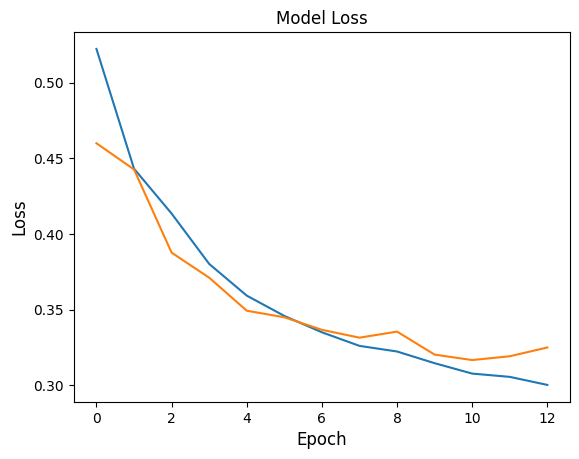

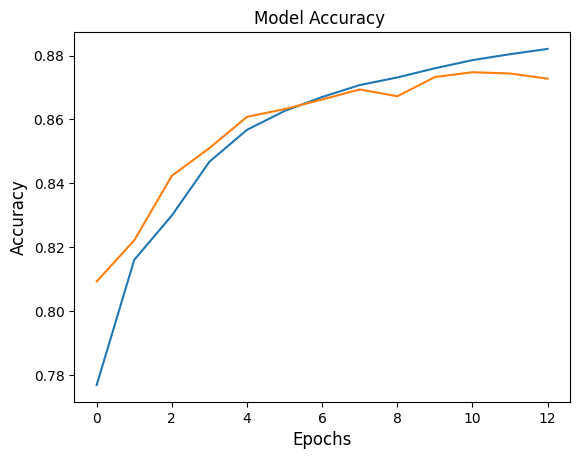

In [102]:
###### Model Plots

plt.plot(history_6.history['dense_20_loss'])
plt.plot(history_6.history['val_dense_20_loss'])
plt.title('Model Loss',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.show()

plt.plot(history_6.history['dense_20_accuracy'])
plt.plot(history_6.history['val_dense_20_accuracy'])
plt.title('Model Accuracy ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.xlabel('Epochs',fontsize=12)
plt.show()

#### Save Model

In [106]:
google_lenet.save('/home/FYP/phase2/Phase2_data/Googlenet/GoogLenet_-final.h5')

In [107]:
google_lenet.save_weights('/home/FYP/phase2/Phase2_data/Googlenet/GoogLenet_-final.tf', save_format='tf')

13429/13429 [==============================] - 93s 7ms/step - loss: 0.9842 - dense_20_loss: 0.3189 - dense_17_loss: 0.3421 - dense_19_loss: 0.3232 - dense_20_accuracy: 0.8758 - dense_17_accuracy: 0.8640 - dense_19_accuracy: 0.8720
13429/13429 - 86s - 86s/epoch - 6ms/step
Confusion matrix, without normalization
[[62606  1807   996]
 [ 4781 17286  1811]
 [ 3885  1330 12924]]


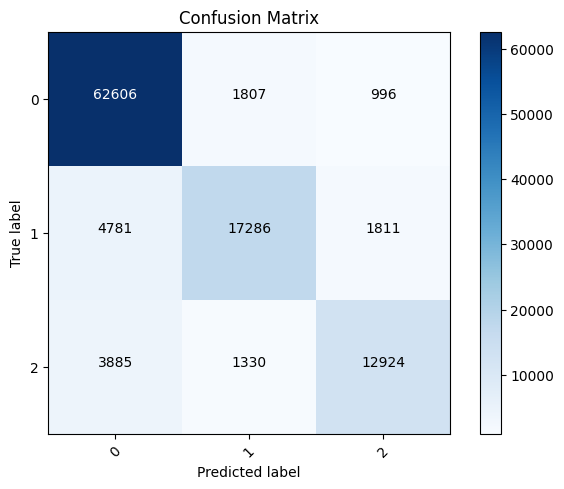

In [103]:
###### Test Model

google_lenet.evaluate(test_batches)

predictions_6 = google_lenet.predict(test_batches, verbose = 2)

y_pred = np.argmax(predictions_6[1], axis = 1)
y_test=test_batches.classes

cm = confusion_matrix(y_test, y_pred)

cm_plot_labels = [0, 1, 2]
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [104]:
accuracy_score(y_test, y_pred)

0.8639994042410589

In [105]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names,digits = 5))

              precision    recall  f1-score   support

     class 0    0.87841   0.95715   0.91609     65409
     class 1    0.84640   0.72393   0.78039     23878
     class 2    0.82156   0.71250   0.76315     18139

    accuracy                        0.86400    107426
   macro avg    0.84879   0.79786   0.81988    107426
weighted avg    0.86170   0.86400   0.86010    107426



## Vgg16

In [80]:
##### VGG16

###### Import and Build Model

vgg16_model = keras.applications.vgg16.VGG16()

model_2 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model_2.add(layer)

# for layer in model.layers:
#     layer.trainable = False

model_2.add(Dense(3, activation = 'softmax'))

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2022-09-22 05:45:03.256268: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


Epoch 1/30
31333/31333 [==============================] - 3454s 110ms/step - loss: 0.4785 - accuracy: 0.8002 - val_loss: 0.4200 - val_accuracy: 0.8307
Epoch 2/30
31333/31333 [==============================] - 3416s 109ms/step - loss: 0.4061 - accuracy: 0.8342 - val_loss: 0.3979 - val_accuracy: 0.8382
Epoch 3/30
31333/31333 [==============================] - 3386s 108ms/step - loss: 0.3812 - accuracy: 0.8442 - val_loss: 0.3772 - val_accuracy: 0.8472
Epoch 4/30
31333/31333 [==============================] - 3342s 107ms/step - loss: 0.3650 - accuracy: 0.8521 - val_loss: 0.3588 - val_accuracy: 0.8552
Epoch 5/30
31333/31333 [==============================] - 3356s 107ms/step - loss: 0.3453 - accuracy: 0.8617 - val_loss: 0.3328 - val_accuracy: 0.8682
Epoch 6/30
31333/31333 [==============================] - 3334s 106ms/step - loss: 0.3249 - accuracy: 0.8714 - val_loss: 0.3233 - val_accuracy: 0.8718
Epoch 7/30
31333/31333 [==============================] - 3334s 106ms/step - loss: 0.3148 - ac

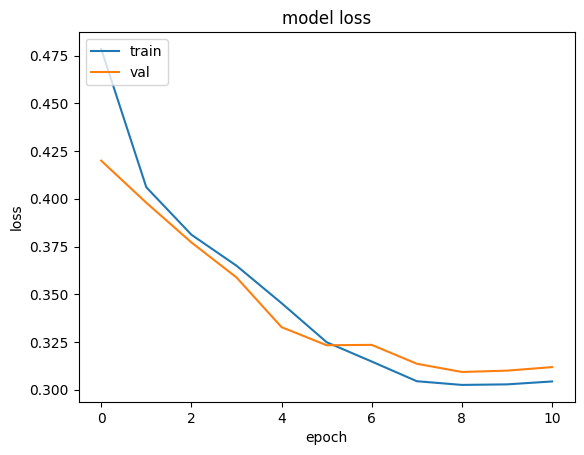

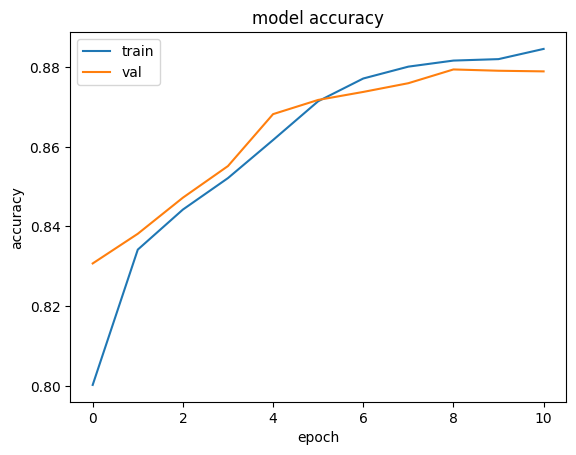

In [81]:
###### Train Model

model_2.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history_2 = model_2.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### save model

In [87]:
model_2.save('/home/FYP/phase2/Phase3_baseline/VGG16/VGG16_baseline.h5')

In [88]:
model_2.save_weights('/home/FYP/phase2/Phase3_baseline/VGG16/VGG16_baseline.tf', save_format='tf')

13429/13429 [==============================] - 227s 17ms/step - loss: 0.3087 - accuracy: 0.8812
13429/13429 - 211s - 211s/epoch - 16ms/step
Confusion matrix, without normalization
[[60727  3140  1542]
 [ 2675 19750  1453]
 [ 2235  1720 14184]]


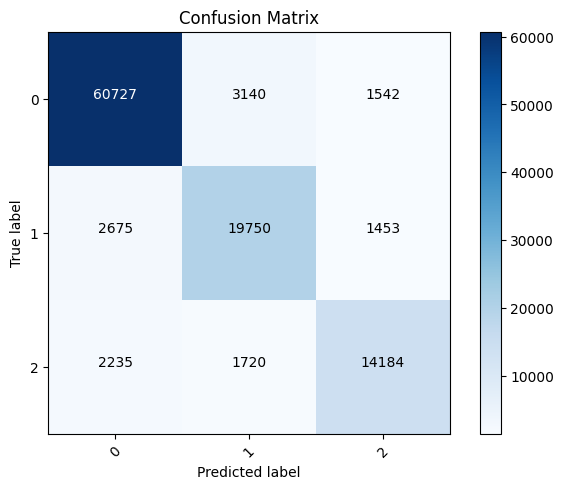

In [84]:
###### Test Model

model_2.evaluate(test_batches)

predictions_2 = model_2.predict(test_batches, verbose = 2)

y_test=test_batches.classes
y_pred = np.argmax(predictions_2, axis = 1)

accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

cm_plot_labels = [0, 1, 2]
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [86]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

     class 0    0.92519   0.92842   0.92680     65409
     class 1    0.80252   0.82712   0.81463     23878
     class 2    0.82566   0.78196   0.80322     18139

    accuracy                        0.88117    107426
   macro avg    0.85112   0.84583   0.84822    107426
weighted avg    0.88112   0.88117   0.88100    107426



END

**Signed By:**

Muiz Alvi

Adil Jowad Qureshi